# Part 1. Gender Classification from audio files

The goal of this part of the assignment is to perform a gender classification task. We will train different ML algorithms on OpenSLR's [LibriSpeech corpus](http://www.openslr.org/12/). LibriSpeech is a corpus of read speech, based on LibriVox's public domain
audio books. Its purpose is to enable the training and testing of automatic
speech recognition (ASR) systems. 

We will use the _dev-clean_ subset of the corpus, a development set containing "clean" speech, which consists of audio files of 40 speakers, labelled by gender.





## Imports

In [1]:
import glob
import os
from collections import Counter
import math
import datetime
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import seaborn as sns
import soundfile as sf
from python_speech_features import mfcc
from sklearn import preprocessing
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

import torch
from torch.utils.data import Dataset, DataLoader

## File paths and global variables

In [2]:
SPEAKERS_METADATA = "./LibriSpeech/SPEAKERS.TXT"
DEV_CLEAN = "./LibriSpeech/dev-clean/"

In [3]:
NUMCEP = 40
SPLIT_RATIO = 0.5
SPEAKER_MEAN_MFCCs = False

In [4]:
# write results to text file
with open("results.txt", "a") as f:
    f.write(f"\n------------------------------------------------------------\n")
    f.write(f"\nGender Classification log - {datetime.datetime.now()}")

    f.write("\n\nSettings:")
    f.write(f"\n• Split ratio = {SPLIT_RATIO}")
    f.write(f"\n• Numcep = {NUMCEP}")
    f.write(f"\n• Speaker Mean MFCCs = {SPEAKER_MEAN_MFCCs}")

## Load data

### Get ids and genres from metadata

READERS.TXT contains information about speaker's gender and total amount of audio in the whole corpus.

In [5]:
speakers_gender = {}

with open(SPEAKERS_METADATA) as f:
    for line in f:
        if ";" not in line:
            speaker_id = int(line.split("|")[0])
            gender = line.split("|")[1].strip()
            speakers_gender[speaker_id] = 0 if gender == 'M' else 1
            
print(f"Total number of speakers in whole corpus:  {len(speakers_gender):>5,}")

Total number of speakers in whole corpus:  2,484


### Get ids and genres for "dev-clean" subset

In [6]:
# get all speakers ids in dev-clean subset of the corpus folder
speaker_ids = [int(speaker_dir) for speaker_dir in os.listdir(DEV_CLEAN) if not speaker_dir.startswith('.') ]
male_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 0]
female_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 1]

print(f"Number of speakers in dev-clean's subset:  {len(speaker_ids):>5,}")
print(f"• Number of male speakers:                 {len(male_ids):>5,}")
print(f"• Number of female speakers:               {len(female_ids):>5,}")

Number of speakers in dev-clean's subset:     40
• Number of male speakers:                    20
• Number of female speakers:                  20


## Build dataset

### Define functions

In [7]:
def extract_mfcc_features(speaker_id):
    speaker_mfcc = np.zeros((0, NUMCEP))  # create new array for mfcc features for this speaker
    user_audio_file_count = 0 
    
    speaker_path = DEV_CLEAN + str(speaker_id)
    print(f"Speaker {speaker_id:>4}:", end=" ")
    
    for path in glob.glob(f'{speaker_path}/*/*.flac', recursive=True):        
        with open(path, 'rb') as f:
            data, samplerate = sf.read(f)    
            
        mfcc_features = mfcc(data, samplerate, numcep=NUMCEP, nfilt=NUMCEP)    
        mfcc_features_mean = np.expand_dims(np.mean(mfcc_features, axis=0), axis=1).T    
        speaker_mfcc = np.vstack((speaker_mfcc, mfcc_features_mean))
        
        user_audio_file_count += 1

    print(f"{user_audio_file_count:>3} audio files", end=", ")

    return speaker_mfcc

In [8]:
def build_dataset(speaker_ids, speakers_gender):
    
    dataset = np.zeros((0,NUMCEP+1))  # dataset is comprised of 13 features (MFCCs) and 1 label

    for i, speaker_id in enumerate(tqdm(speaker_ids, desc='Extracting MFCCs')):
        
        speaker_mfcc = extract_mfcc_features(speaker_id)
        
        if SPEAKER_MEAN_MFCCs == True:
            # take the mean of the mfcc's for each speaker
            speaker_mfcc = np.expand_dims(np.mean(speaker_mfcc, axis=0), axis=1).T   
        
        # gender column to be added for this user
        gender = speakers_gender[int(speaker_id)]
        print(f"gender {gender} {'(M)' if gender==0 else '(F)'}")

        gender_col = np.empty(speaker_mfcc.shape[0])
        gender_col.fill(gender)

        # Adding gender column to 2D NumPy Array
        speaker_mfcc_gender = np.column_stack((speaker_mfcc, gender_col))


        # add this user to all users
        dataset = np.vstack((dataset, speaker_mfcc_gender))

    return dataset

In [9]:
def split_speakers(speaker_ids, ratio, seed=1):
    
    np.random.seed(seed)  # set seed

    # generate random indices
    indices = np.random.permutation(len(speaker_ids))
    
    # calculate number of samples in training set
    nb_tr_samples = int(np.floor(ratio * len(speaker_ids)))
    
    # split the indices between training an testing set
    ind_tr = indices[:nb_tr_samples]
    ind_te = indices[nb_tr_samples:]
    
    # get ids corresponding to indices
    speakers_ids_tr = [speaker_ids[i] for i in ind_tr]
    speakers_ids_te = [speaker_ids[i] for i in ind_te]
    
    return speakers_ids_tr, speakers_ids_te

### Split speaker ids for train and test sets

In [10]:
print(f"Split train / test sets ({SPLIT_RATIO:.0%}/{1-SPLIT_RATIO:.0%}) for male and female speakers: ")
male_ids_train, male_ids_test = split_speakers(male_ids, SPLIT_RATIO)
female_ids_train, female_ids_test = split_speakers(female_ids, SPLIT_RATIO)

print(f"• Number of male ids for train set:   {len(male_ids_train):>3}")
print(f"• Number of female ids for train set: {len(female_ids_train):>3}")
print(f"• Number of male ids for test set:    {len(male_ids_test):>3}")
print(f"• Number of female ids for test set:  {len(female_ids_test):>3}")

Split train / test sets (50%/50%) for male and female speakers: 
• Number of male ids for train set:    10
• Number of female ids for train set:  10
• Number of male ids for test set:     10
• Number of female ids for test set:   10


In [11]:
with open("results.txt", "a") as f:
    f.write(f"\n\nSpeaker ids for train and test sets")
    
    f.write(f"\n• Number of male ids for train set:   {len(male_ids_train):>3}")
    f.write(f"\n• Number of female ids for train set: {len(female_ids_train):>3}")
    f.write(f"\n• Number of male ids for test set:    {len(male_ids_test):>3}")
    f.write(f"\n• Number of female ids for test set:  {len(female_ids_test):>3}")

### Extract MFCC features from audio files

In [12]:
print("Build train dataset: ")
train_dataset = build_dataset(male_ids_train + female_ids_train, speakers_gender)
print(train_dataset.shape, "\n")

print("Build test dataset: ")
test_dataset = build_dataset(male_ids_test + female_ids_test, speakers_gender)
print(test_dataset.shape, "\n")

Build train dataset: 


Extracting MFCCs:   0%|          | 0/20 [00:00<?, ?it/s]

Speaker 3000:  47 audio files, gender 0 (M)
Speaker 8297:  75 audio files, gender 0 (M)
Speaker  174:  59 audio files, gender 0 (M)
Speaker  777:  82 audio files, gender 0 (M)
Speaker  422:  36 audio files, gender 0 (M)
Speaker 2428:  87 audio files, gender 0 (M)
Speaker  251:  75 audio files, gender 0 (M)
Speaker  652:  71 audio files, gender 0 (M)
Speaker 6295:  74 audio files, gender 0 (M)
Speaker 3752: 101 audio files, gender 0 (M)
Speaker 1993:  58 audio files, gender 1 (F)
Speaker   84:  65 audio files, gender 1 (F)
Speaker 7850:  72 audio files, gender 1 (F)
Speaker 3536:  64 audio files, gender 1 (F)
Speaker 1919:  64 audio files, gender 1 (F)
Speaker 5338:  59 audio files, gender 1 (F)
Speaker 6313:  96 audio files, gender 1 (F)
Speaker 3576:  41 audio files, gender 1 (F)
Speaker 1462:  94 audio files, gender 1 (F)
Speaker 1988:  75 audio files, gender 1 (F)
(1395, 41) 

Build test dataset: 


Extracting MFCCs:   0%|          | 0/20 [00:00<?, ?it/s]

Speaker 6241:  78 audio files, gender 0 (M)
Speaker 2078:  52 audio files, gender 0 (M)
Speaker 1272:  73 audio files, gender 0 (M)
Speaker 3170:  49 audio files, gender 0 (M)
Speaker 2803:  57 audio files, gender 0 (M)
Speaker 2902:  38 audio files, gender 0 (M)
Speaker 7976:  78 audio files, gender 0 (M)
Speaker 2086:  55 audio files, gender 0 (M)
Speaker 5694:  83 audio files, gender 0 (M)
Speaker 5536:  59 audio files, gender 0 (M)
Speaker 3853:  57 audio files, gender 1 (F)
Speaker 2412:  58 audio files, gender 1 (F)
Speaker 2035:  77 audio files, gender 1 (F)
Speaker 1673:  42 audio files, gender 1 (F)
Speaker 2277:  95 audio files, gender 1 (F)
Speaker 6319:  55 audio files, gender 1 (F)
Speaker 5895:  80 audio files, gender 1 (F)
Speaker 6345:  77 audio files, gender 1 (F)
Speaker 3081:  90 audio files, gender 1 (F)
Speaker 8842:  55 audio files, gender 1 (F)
(1308, 41) 



### Separate features and label

In [13]:
X_train = train_dataset[:, :NUMCEP]
y_train = train_dataset[:, NUMCEP:]

X_test = test_dataset[:, :NUMCEP]
y_test = test_dataset[:, NUMCEP:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1395, 40), (1395, 1), (1308, 40), (1308, 1))

## EDA

In [14]:
male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

male_test_idx = np.where(y_test == 0)
female_test_idx = np.where(y_test == 1)

total_files = len(X_train)+len(X_test)

print(f"Total audio files in dataset:   {total_files:>6,}")
print()
print(f"Audio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
print(f"• Male files:                   {len(male_train_idx[0]):>6,}")
print(f"• Female files:                 {len(female_train_idx[0]):>6,}")
print()
print(f"Audio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
print(f"• Male files:                   {len(male_test_idx[0]):>6,}")
print(f"• Female files:                 {len(female_test_idx[0]):>6,}")

Total audio files in dataset:    2,703

Audio files in train dataset:    1,395 (51.61%)
• Male files:                      707
• Female files:                    688

Audio files in test dataset:     1,308 (48.39%)
• Male files:                      622
• Female files:                    686


In [15]:
with open("results.txt", "a") as f:
    f.write(f"\n\nTotal audio files in dataset:   {total_files:>6,}")

    f.write(f"\n\nAudio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
    f.write(f"\n• Male files:                   {len(male_train_idx[0]):>6,}")
    f.write(f"\n• Female files:                 {len(female_train_idx[0]):>6,}")

    f.write(f"\n\nAudio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
    f.write(f"\n• Male files:                   {len(male_test_idx[0]):>6,}")
    f.write(f"\n• Female files:                 {len(female_test_idx[0]):>6,}")

In [16]:
sns.set_theme(style="whitegrid")

In [17]:
def show_hist_box(data, attr_list, title, img_path, do_save_to_disk):
    """
    Plots aligned histograms and boxplots.
    Args:
        x: shape=(N,D) data array
        attr_list: shape=(D,) list of strings
        title: the title of the plot
        img_path: the path to save the plot
        do_save_to_disk: boolean, whether to save the plot to disk
    """
    fig = plt.figure(figsize=(18, 30))
    outer = gridspec.GridSpec(math.ceil(NUMCEP/3), 3, wspace=0.2, hspace=0.5, top=0.950, bottom=0.03)

    for i, attribute in enumerate(attr_list):
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[i], hspace=0.1, height_ratios=[1, 4]
        )

        # Boxplot
        ax0 = plt.Subplot(fig, inner[0])
        sns.boxplot(x=data[:, i], ax=ax0)
        fig.add_subplot(ax0)
        ax0.set(xlabel="")
        ax0.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=False,  # labels along the bottom edge are off
        )  

        # Histogram
        ax1 = plt.Subplot(fig, inner[1])
        sns.histplot(data[:, i], bins=50, ax=ax1)
        fig.add_subplot(ax1)
        ax1.set_xlabel(f"{attr_list[i]}")

    # Set title
    fig.suptitle(f"{title}\n({len(data):,} frames)", fontweight="bold")

    # Save to disk
    if do_save_to_disk == True:
        filename = (
            "histplot_"
            + str(title).lower().replace(" ", "_").replace("$", "").replace("'", "")
            + ".jpg"
        )
        fig.savefig(img_path + filename, dpi=300, bbox_inches="tight")

    plt.show()

### Distribution of features

_If a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. ([source](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040))_

#### Male + Female

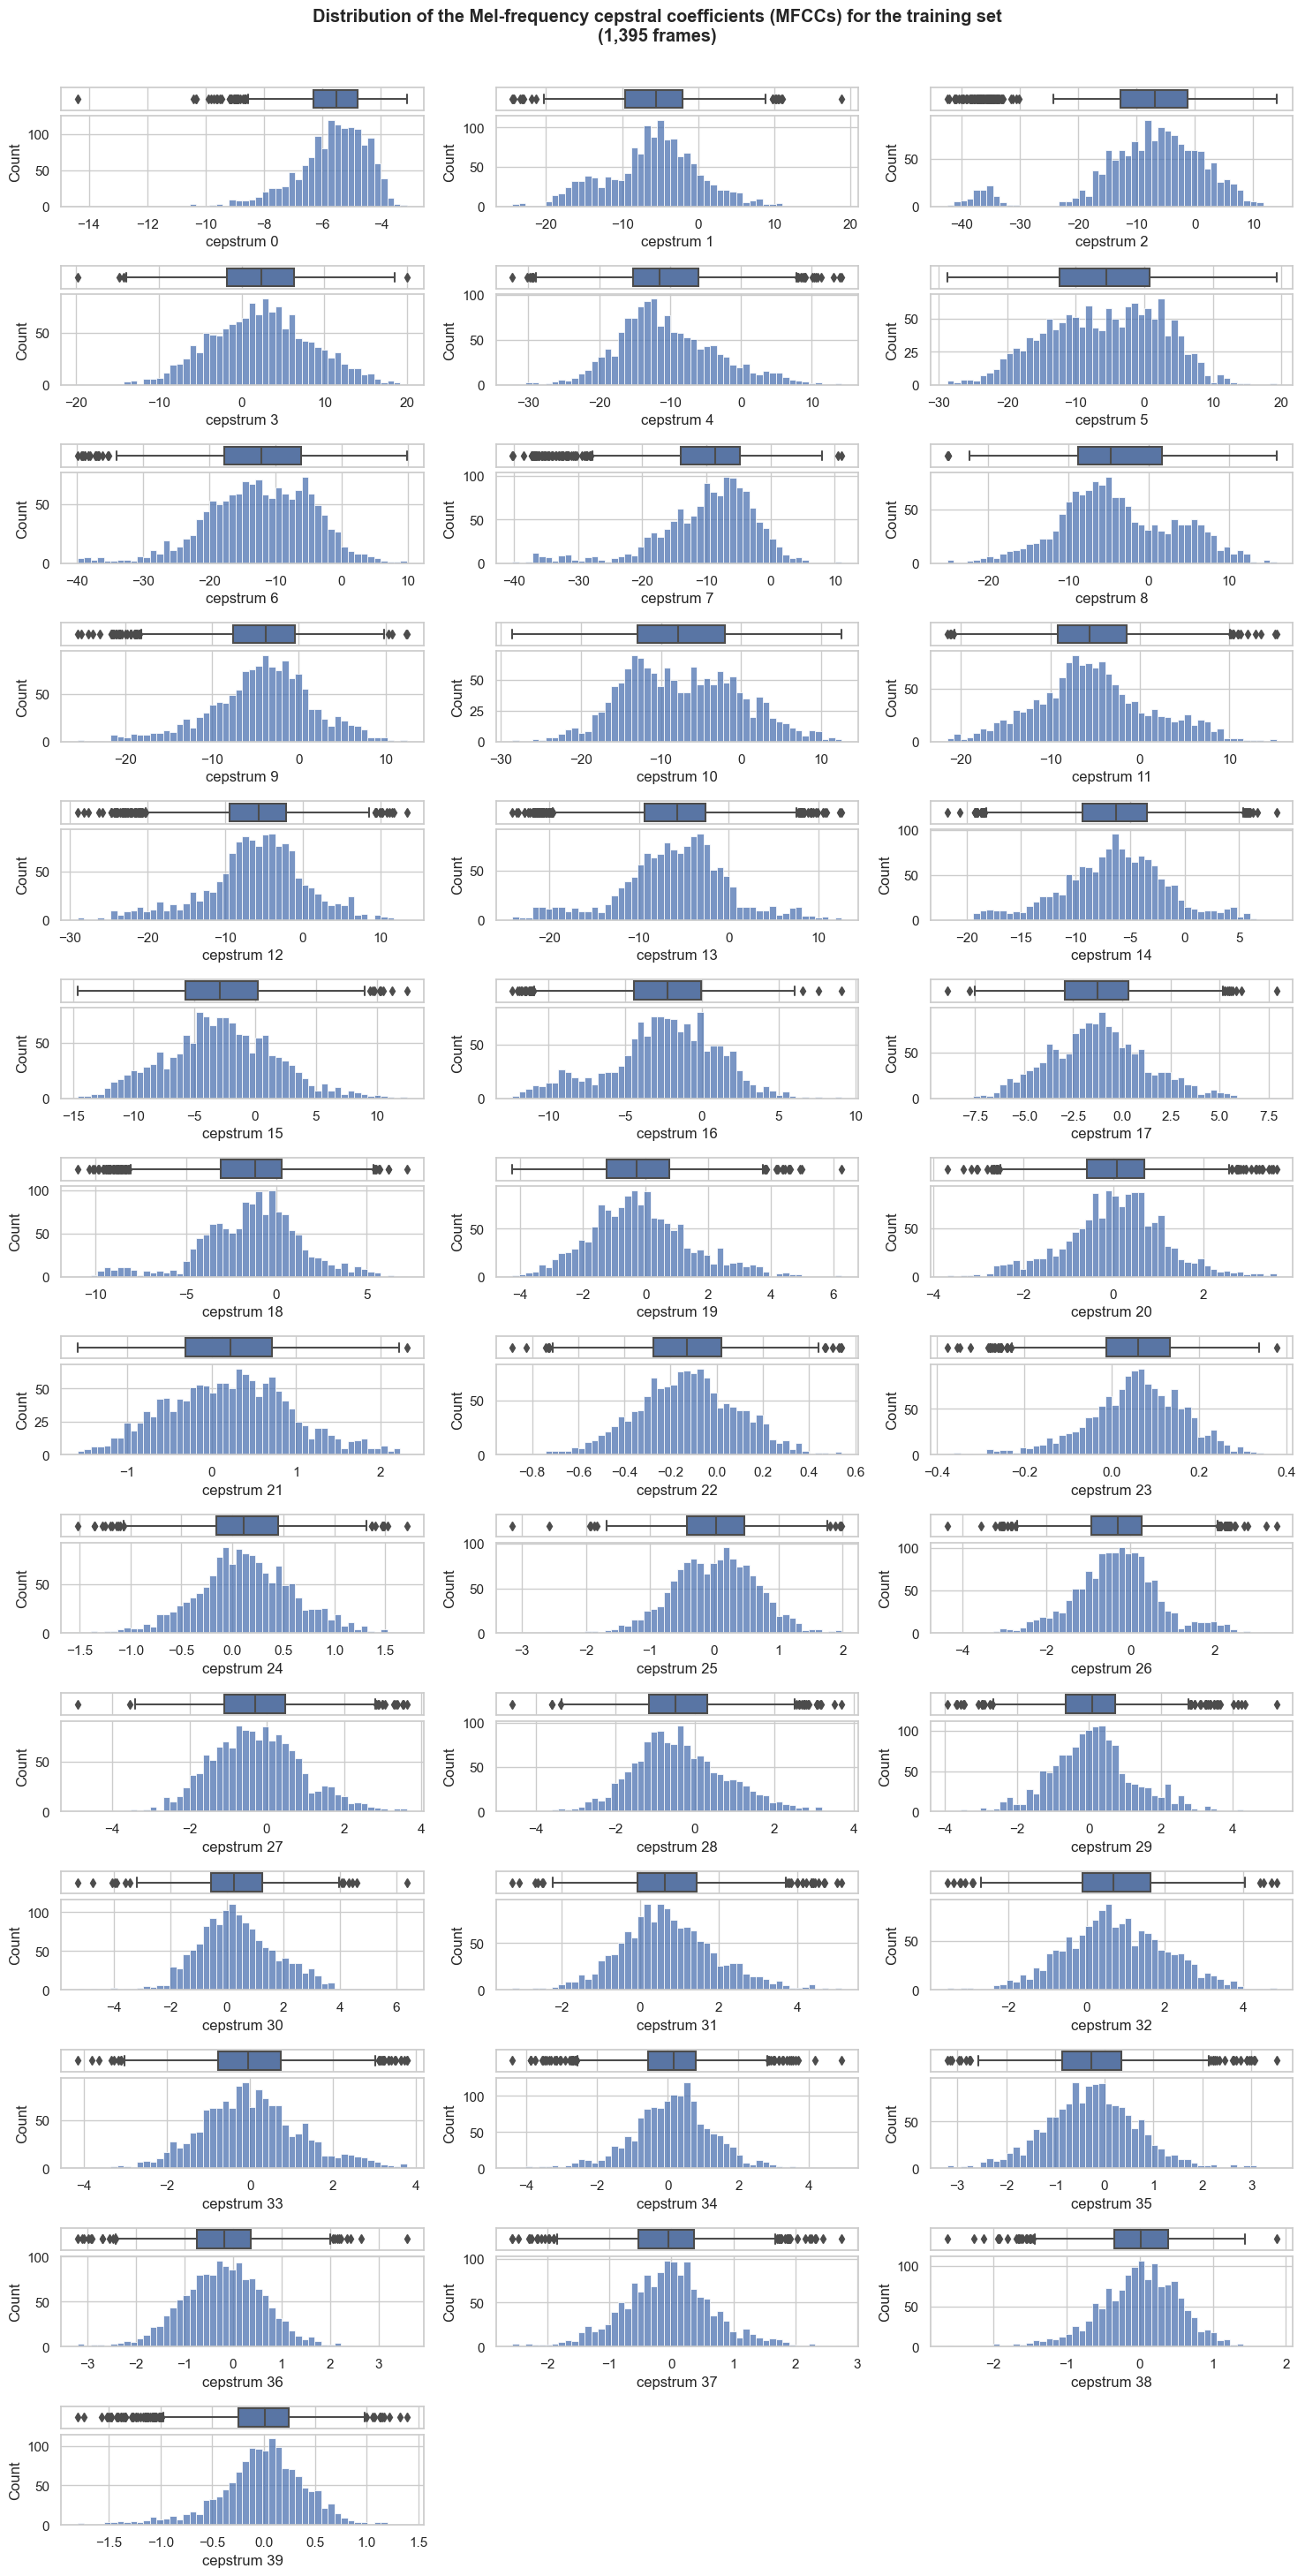

In [18]:
attr_list = ["cepstrum "+str(i) for i in range(0,NUMCEP)]
show_hist_box(X_train, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set", img_path="img/", do_save_to_disk=False)

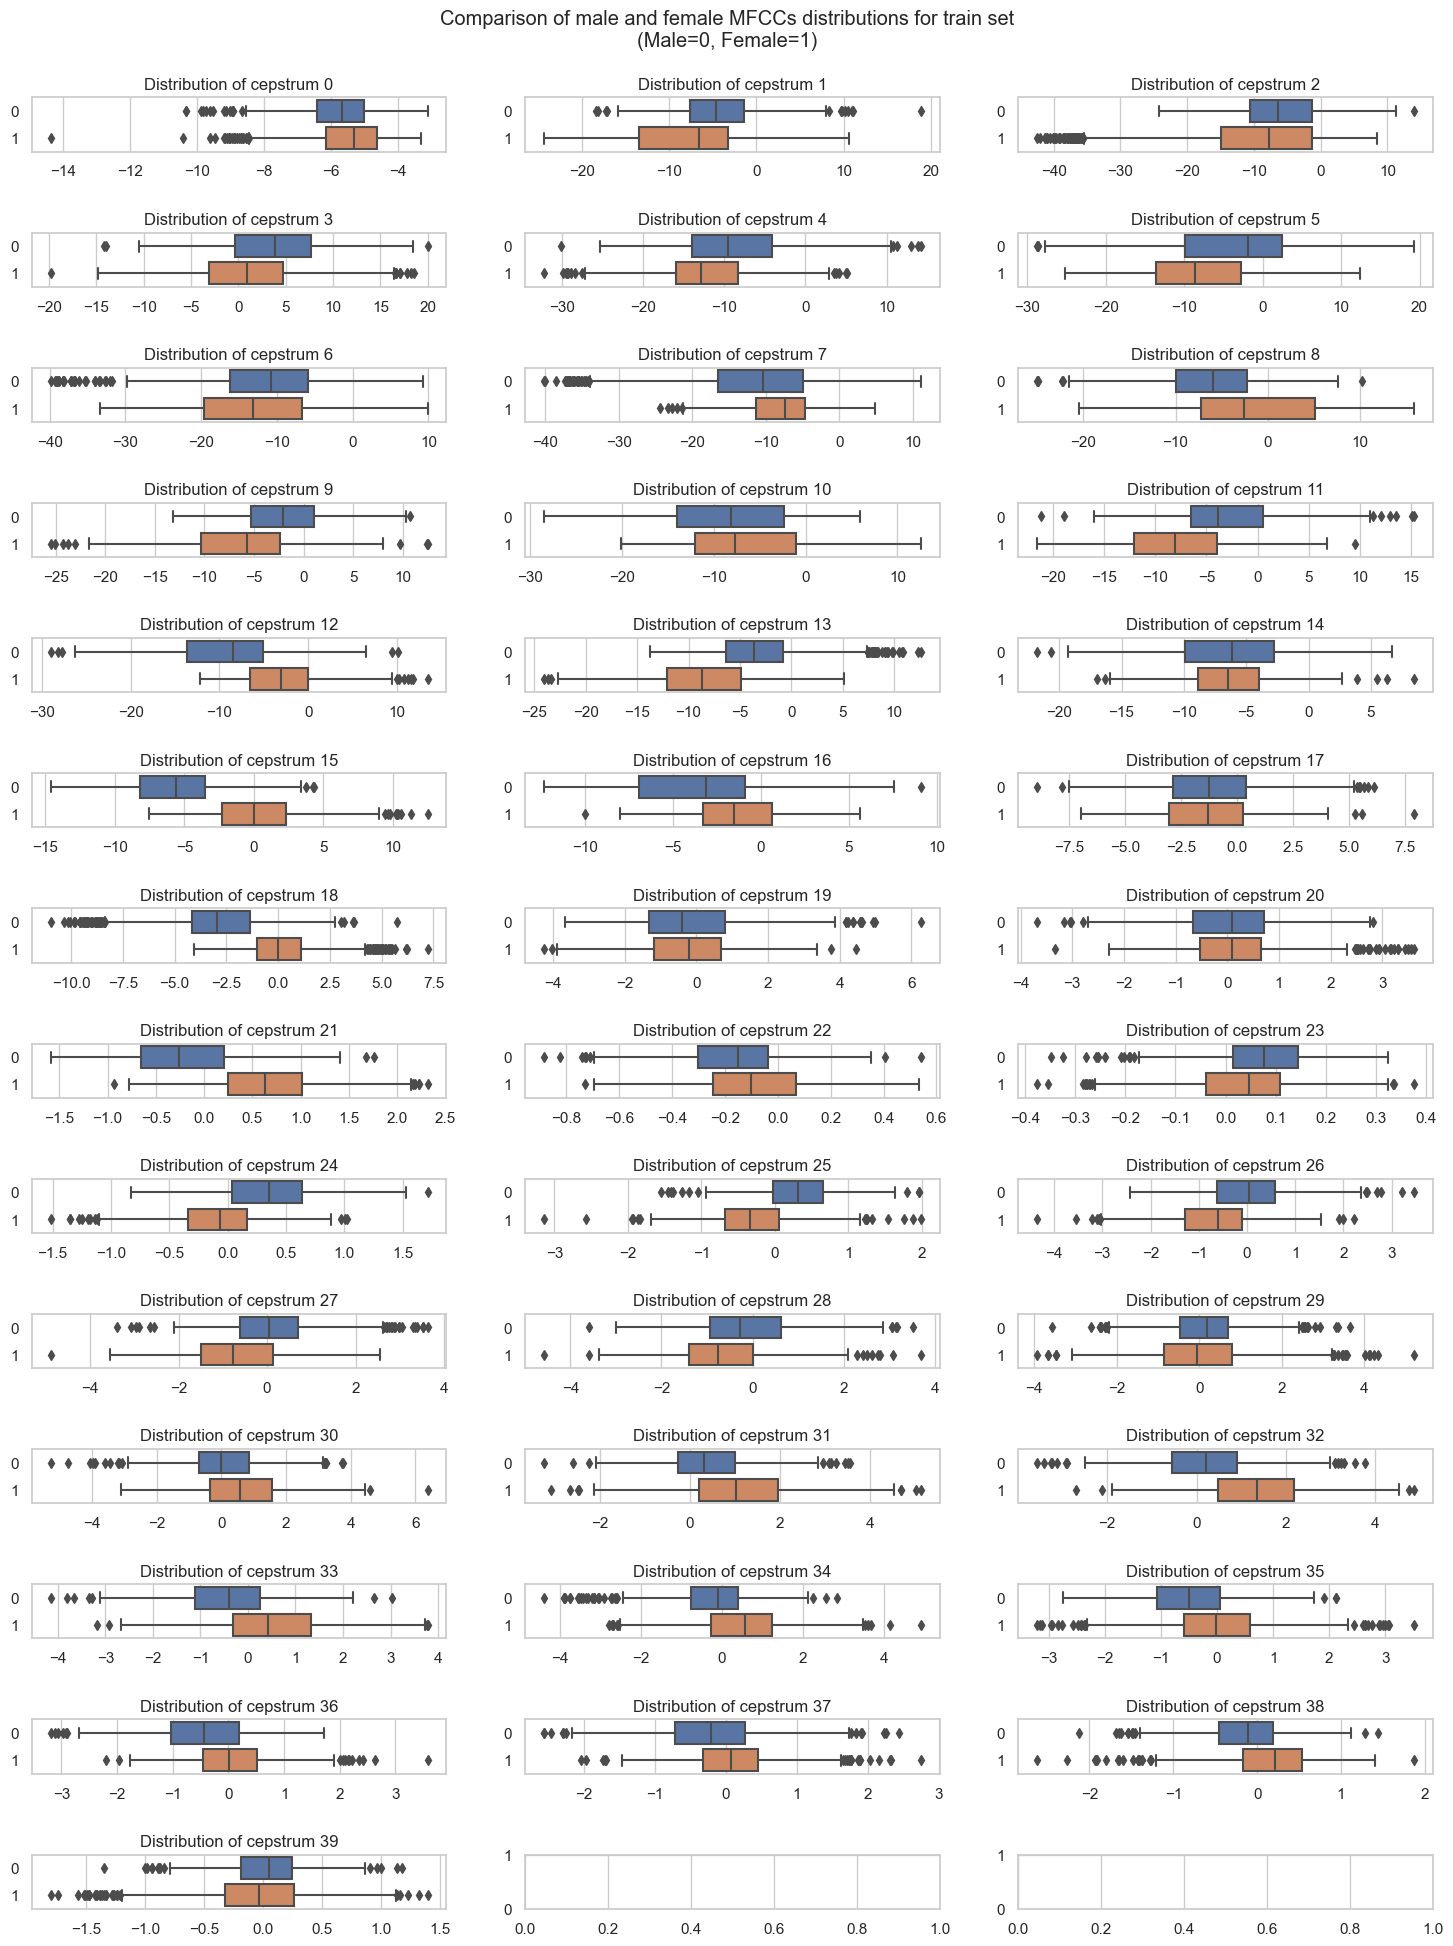

In [19]:
# Compare male and female data (before removing outliers)

male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

fig, axs = plt.subplots(nrows=math.ceil(NUMCEP/3), ncols=3, figsize=(15,20), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train[np.ix_(male_train_idx[0], [i])].T, X_train[np.ix_(female_train_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

### Remove outliers
Removing Outliers using Interquartile Range 

In [20]:
# # Computer lower and upper bounds
# Q1, Q3 = np.percentile(X_train, [25,75], axis=0)
# IQR = Q3 - Q1
# lower_bounds = Q1 - 1.5 * IQR
# upper_bounds = Q3 + 1.5 * IQR

# with np.printoptions(precision=2):
#     print(f"• Q1: {Q1}")
#     print(f"• Q3: {Q3}")
#     print(f"• IQR:{IQR}")
#     print()
#     print(f"• lower_bounds (Q1 - 1.5 * IQR): \n{lower_bounds}")
#     print(f"• upper_bounds (Q3 + 1.5 * IQR): \n{upper_bounds}")

In [21]:
# # find indexes of all rows above lower bounds
# rows_above_lower_bounds_idx = np.all(np.greater(X_train, lower_bounds), axis=1)

# # find indexes of all rows below upper bounds
# rows_below_upper_bounds_idx = np.all(np.less(X_train, upper_bounds), axis=1)

# # find indexes of all rows inside bounds
# rows_inside_bounds = np.logical_and(rows_above_lower_bounds_idx, rows_below_upper_bounds_idx)

# # keep only rows that have values above lower bounds
# X_train_no_outliers = X_train[rows_inside_bounds, :]
# y_train_no_outliers = y_train[rows_inside_bounds, :]

# count_removed = len(X_train) - len(X_train_no_outliers)
# print(f"Removed {count_removed:,} outliers ({count_removed/len(X_train):.1%})")

#### Male + Female (without outliers)

In [22]:
# show_hist_box(X_train_no_outliers, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

In [23]:
# male_train_no_outliers_idx = np.where(y_train_no_outliers == 0)
# female_train_no_outliers_idx = np.where(y_train_no_outliers == 1)

#### Male only (without outliers)

In [24]:
# show_hist_box(X_train_no_outliers[male_train_no_outliers_idx[0], :], attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

#### Female only (without outliers)

In [25]:
# show_hist_box(X_train_no_outliers[female_train_no_outliers_idx[0], :], attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

#### Male and Female comparison (no outliers)

In [26]:
# fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15,20), sharex=False, sharey=False)
# for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
#     sns.boxplot(data=[X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T, X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T], orient="h", ax=ax)
#     ax.set(title=f'Distribution of {col}')
# plt.suptitle(f'Comparison of male and female MFCCs distributions for train set, after removing outliers\n(Male=0, Female=1)')
# plt.tight_layout(pad=2)
# plt.show()

**Observations:**

According to [Emmanuel Deruty](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040), if a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. 

We notice that for most cepstrum coefficients (1, 2, 3, 4, 5, 6, 9, 10, 11), the distributions of the male values are higher than the female ones, which matches the intuition that the male voice generally has a lower frequency than a female's voice.

### Normalize data

In [27]:
# if we don't remove outliers
X_train_no_outliers = X_train
y_train_no_outliers = y_train

In [28]:
X_train.shape

(1395, 40)

In [29]:
print("Before normalization: ")
with np.printoptions(precision=2):
    print(f"\n• X_train_no_outliers means: {np.mean(X_train_no_outliers, axis=0)}")
    print(f"\n• X_train_no_outliers std:   {np.std(X_train_no_outliers, axis=0)}")
    print(f"\n• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"\n• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train_no_outliers, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\n\nAfter normalization: ")
with np.printoptions(precision=2):
    print(f"\n• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"\n• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"\n• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"\n• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 

• X_train_no_outliers means: [-5.68e+00 -5.96e+00 -8.15e+00  2.40e+00 -1.04e+01 -5.97e+00 -1.24e+01
 -1.01e+01 -3.82e+00 -4.24e+00 -7.33e+00 -5.17e+00 -6.16e+00 -6.04e+00
 -6.44e+00 -2.82e+00 -2.54e+00 -1.23e+00 -1.39e+00 -1.60e-01  3.97e-02
  2.11e-01 -1.29e-01  5.41e-02  1.35e-01  7.59e-03 -3.14e-01 -2.56e-01
 -3.79e-01  1.22e-01  3.85e-01  7.17e-01  7.48e-01  3.62e-02  1.27e-01
 -2.56e-01 -2.01e-01 -5.92e-02 -6.01e-03 -2.17e-02]

• X_train_no_outliers std:   [ 1.21  6.16 10.24  6.09  7.18  8.39  8.09  8.09  7.2   5.93  7.2   6.41
  6.62  6.07  4.8   4.53  3.57  2.48  2.83  1.59  1.09  0.74  0.22  0.11
  0.48  0.64  1.02  1.17  1.17  1.2   1.4   1.23  1.31  1.22  1.17  0.95
  0.84  0.74  0.56  0.44]

• X_test means:  [ -5.29  -6.44  -9.56   0.32 -14.39 -14.07 -11.73  -8.28  -0.1   -1.43
  -5.54  -5.22  -6.05  -4.59  -6.87  -1.83  -2.08  -0.31  -0.38   0.02
   0.02   0.24  -0.1    0.07   0.19  -0.05  -0.26  -0.57  -0.45   0.35
   0.36   1.     0.59  -0.13   0.2

## Train ML models

### Naive Bayes classifier

In [31]:
clf = GaussianNB()
clf.fit(X_train_norm, y_train_no_outliers.ravel())
display(clf)

print("Gaussian Naive Bayes classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

GaussianNB()

Gaussian Naive Bayes classifier:
• Mean training accuracy:  94.19%
• Mean testing accuracy:   86.31%


In [32]:
with open("results.txt", "a") as f:
    f.write("\n\nGaussian Naive Bayes classifier:")
    f.write(f"\n• Mean training accuracy: {train_acc:>7.2%}")
    f.write(f"\n• Mean testing accuracy:  {test_acc:>7.2%}")

### Logistic Regression

In [33]:
clf = LogisticRegression(random_state=0)
display(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Logistic regression classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

LogisticRegression(random_state=0)

Logistic regression classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   88.99%


In [34]:
with open("results.txt", "a") as f:
    f.write("\n\nLogistic regression classifier:")
    f.write(f"\n• Mean training accuracy: {train_acc:>7.2%}")
    f.write(f"\n• Mean testing accuracy:  {test_acc:>7.2%}")

### Support Vector Machines

In [35]:
print("SVM classifier:")

with open("results.txt", "a") as f:
    f.write("\n\nSVM classifier:")
        
# Try training with different degrees of the polynomial kernel function
for degree in range(1,4):
    clf = svm.SVC(kernel='poly', degree=degree)
    display(clf)
    clf.fit(X_train_norm, y_train.ravel())
    
    # compute mean accuracy on the train data and labels.
    train_acc = clf.score(X_train_norm, y_train_no_outliers)
    print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

    # compute mean accuracy on the test data and labels.
    test_acc = clf.score(X_test_norm, y_test)
    print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
    print()
    
    with open("results.txt", "a") as f:
        f.write(f"\n• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")
        f.write(f"\n• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")

SVM classifier:


SVC(degree=1, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 1):  99.35%
• Mean testing accuracy  (polynomial kernel of degree 1):  88.61%



SVC(degree=2, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 2): 100.00%
• Mean testing accuracy  (polynomial kernel of degree 2):  59.86%



SVC(kernel='poly')

• Mean training accuracy (polynomial kernel of degree 3): 100.00%
• Mean testing accuracy  (polynomial kernel of degree 3):  88.00%



### Random Forest classifier

In [36]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
clf.fit(X_train_norm, y_train_no_outliers.ravel())
display(clf)

print("Random Forest classifier:")

train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

RandomForestClassifier(max_depth=4, random_state=0)

Random Forest classifier:
• Mean training accuracy:  98.64%
• Mean testing accuracy:   86.47%


In [37]:
start_time = time.time()

# parameters for GridSearch
param_grid = [{'n_estimators': [100,500,1000], 'max_features':['sqrt']}]

### Training and Evaluating Random Forest Regressor
clf = RandomForestClassifier()

#### Fine-Tune the model using Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=3)

grid_search.fit(X_train_norm, y_train_no_outliers.ravel())
best_clf = grid_search.best_estimator_
print(best_clf)

elapsed_time = time.time() - start_time
print(f"Elapsed time to train model: {elapsed_time:.3f} seconds")

train_acc = best_clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = best_clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.932) total time=   0.4s
[CV 2/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.943) total time=   0.4s
[CV 3/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.778) total time=   0.4s
[CV 4/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.781) total time=   0.4s
[CV 5/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.885) total time=   0.4s
[CV 1/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.946) total time=   2.1s
[CV 2/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.932) total time=   1.9s
[CV 3/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.835) total time=   2.2s
[CV 4/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.749) total time=   2.2s
[CV 5/5] END max_featu

In [38]:
with open("results.txt", "a") as f:
    f.write("\n\nRandom Forest classifier:")
    f.write(f"\n• Mean training accuracy: {train_acc:>7.2%}")
    f.write(f"\n• Mean testing accuracy:  {test_acc:>7.2%}")

### Neural Network

In [39]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10, 100, 100), activation='relu', alpha=0.0001, batch_size='auto', learning_rate_init=0.001, max_iter=100)
display(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Neural Network classifier:")

train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

MLPClassifier(hidden_layer_sizes=(10, 100, 100), max_iter=100, random_state=1)

Neural Network classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   83.18%


### Neural Network (PyTorch)

In [40]:
BATCH_SIZE = 128

In [41]:
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [42]:
class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(NUMCEP, 100)
        self.activation1 = torch.nn.ReLU()
        self.hidden_layer1 = torch.nn.Linear(100, 100)
        self.activation2 = torch.nn.ReLU()
        self.hidden_layer2 = torch.nn.Linear(100, 100)
        self.activation3 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(100, 1)
        self.activation_out = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.hidden_layer1(x)
        x = self.activation2(x)
        x = self.hidden_layer2(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        x = self.activation_out(x)
        return x

In [43]:
train_dataset = BinaryDataset(X_train_norm, y_train_no_outliers)
test_dataset = BinaryDataset(X_test_norm, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [44]:
model = NNClassifier()
print(model)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

NNClassifier(
  (input_layer): Linear(in_features=40, out_features=100, bias=True)
  (activation1): ReLU()
  (hidden_layer1): Linear(in_features=100, out_features=100, bias=True)
  (activation2): ReLU()
  (hidden_layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation3): ReLU()
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation_out): Sigmoid()
)


In [45]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (((y_pred > 0.5) * 1.0) == y_batch).sum().item()
        
        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)
        
        print(
            f"Train Epoch: {epoch}-{batch_idx:02d} "
            f"batch_loss={batch_loss:.3f} "
            f"batch_acc={batch_accuracy:.3f} "
        )
    
    return epoch_loss_history, epoch_accuracy_history

In [46]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()

            correct_epoch += (((y_pred > 0.5) * 1.0) == y_batch).sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [47]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=0.693 batch_acc=0.492 
Train Epoch: 1-01 batch_loss=0.687 batch_acc=0.516 
Train Epoch: 1-02 batch_loss=0.675 batch_acc=0.562 
Train Epoch: 1-03 batch_loss=0.676 batch_acc=0.523 
Train Epoch: 1-04 batch_loss=0.671 batch_acc=0.547 
Train Epoch: 1-05 batch_loss=0.663 batch_acc=0.555 
Train Epoch: 1-06 batch_loss=0.672 batch_acc=0.469 
Train Epoch: 1-07 batch_loss=0.659 batch_acc=0.609 
Train Epoch: 1-08 batch_loss=0.654 batch_acc=0.578 
Train Epoch: 1-09 batch_loss=0.664 batch_acc=0.578 
Train Epoch: 1-10 batch_loss=0.643 batch_acc=0.670 
Test set:  Average loss: 0.066, Accuracy: 790/1308 (60.4%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=0.640 batch_acc=0.711 
Train Epoch: 2-01 batch_loss=0.632 batch_acc=0.789 
Train Epoch: 2-02 batch_loss=0.621 batch_acc=0.812 
Train Epoch: 2-03 batch_loss=0.601 batch_acc=0.812 
Train Epoch: 2-04 batch_loss=0.600 batch_acc=0.883 
Train Epoch: 2-05 batch_loss=0.602 

#### Plot train and test curves

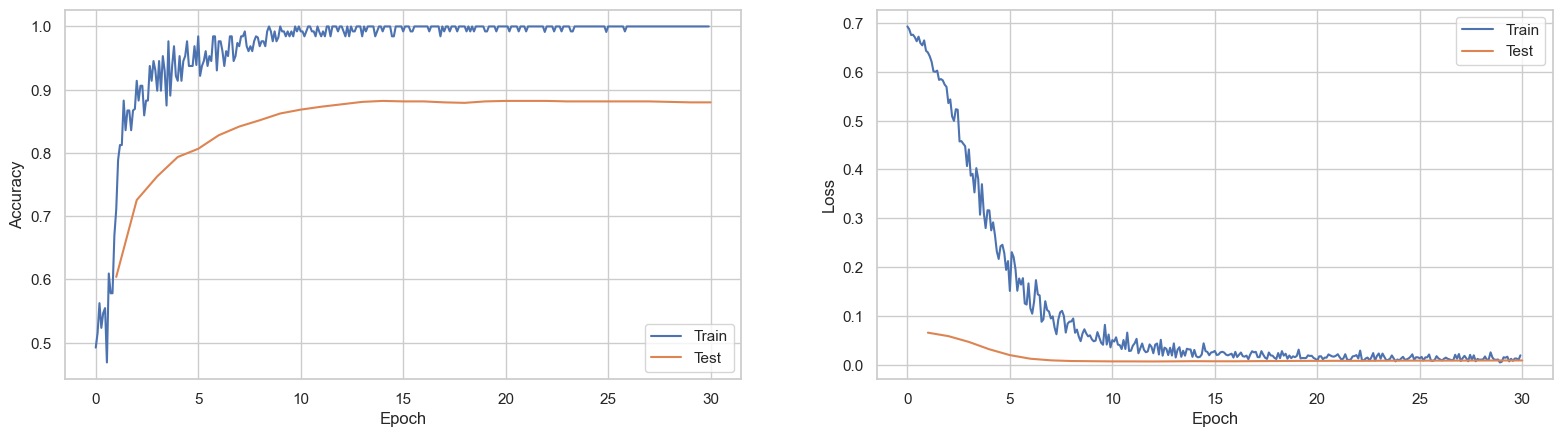

In [48]:
n_train = len(train_acc_history)
t_train = NUM_EPOCHS * np.arange(n_train) / n_train
t_test = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(6.4 * 3, 4.8))
plt.subplot(1, 2, 1)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_test, test_acc_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_test, test_loss_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### CNN